In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import Markdown as md
import numpy
from numpy import dot
from scipy.linalg import eig
from math import pi,sqrt

In [3]:
import matplotlib.pyplot as plt
import numpy
import xlrd
import easy_excel

In [4]:
# chargement des scripts pour la résolution dynamique transitoire
# du problème et l'initialisation des éléments finis
from pyfem.DYNA_NON_LINE import DYNA_NON_LINE
from pyfem.beam import beam
from pyfem.mass import mass
from pyfem.spring import spring
from pyfem.dashpot import dashpot
from pyfem.springNL import springNL
from pyfem.springNLgliss import springNLgliss

# Exemple résolution dynamique transitoire avec ISS linéaire et non-linéaire

<img src="schema_problem.png" width="50%">

* Informations de la structure:

In [5]:
m = 2.2         # kt - masse concentrée en tête de pile
h = 4.          # m - hauteur de la pile
D = 2.5         # m - diamètre de la pile
E = 20000       # MPa - module d'Young du béton de la pile
xi_str = 0.07   # taux d'amortissement de la structure

* Informations sur le sol et la fondation

In [6]:
Vs = 300      # m/s - vitesse des ondes de cisallement
nu = 0.4      # coefficient de Poisson
rho = 0.0021  # kt/m3 - masse volumique du sol
B = 7         # m - largeur de la semelle carrée
phi = 30      # ° - angle de frottement à l'interface sol-fondation

* Calcul de la raideur et de la fréquence fondamentale en base encastrée de la structure

In [8]:
I = pi*D**4/64
k0 = 3*E*I/h**3
w0 = sqrt(k0/m)
f0 = w0/(2*pi)
T0 = 1/f0

* Lecture accélérogramme

In [11]:
# lecture accélérogramme Coalinga
book = xlrd.open_workbook("accélérogrammes.xls")
sheet = book.sheet_by_name("Accélérogrammes")
time,acc = easy_excel.read_interval(sheet,"C3:D10000")
time = numpy.array(time)
acc = numpy.array(acc)*9.81         # to convert to m/s2 units

## Calcul linéaire élastique

In [12]:
# définition des paramètres du modèle
k_str = k0
c_str = 2*m*xi_str*w0
m_str = m

# paramètres modélisation ISS
kh = 5661.762705293346
km = 214134.86542000275

xih = 0.1906677953280259
xim = 0.09011385448909517

weq = 23.724     # pulsation propre mode ISS (rad/s)
feq = 3.776      # fréquence propre mode ISS (Hz)

ch = xih*2*kh/weq
cm = xim*2*km/weq

In [14]:
# calcul de la réponse dynamique transitoire avec ISS linéaire

cas = "Acc2 - Coalinga-05"

model_line ={
    # nombre de degrés de liberté dans le problème
    "n_dof":7,

    # liste qui contient l'information des éléments finis utilisés
    # pour définir le modèle + initialisation des éléments
    "l_elem":[
        # elem / ldofs
        [spring(k=kh),[0,2]],    # kh
        [dashpot(c=ch),[0,2]],    # ch
        [spring(k=km),[1,3]],    # km
        [dashpot(c=cm),[1,3]],    # cm
        # barre rigide
        [beam(L=h,EI=1e12),[2,3,4,5]],    # barre rigide
        # informations structure
        [spring(k=k_str),[4,6]],
        [dashpot(c=c_str),[4,6]],
        [mass(m=m_str),[6]],
    ],

    # liste de ddl bloqués
    "l_dof_bloq": [0,1],

    # liste des ddl libres
    "l_dof_free": [2,3,4,5,6],

    # liste des ddl auquel s'applique le vecteur de chargement équivalent
    "l_dof_earthquake_load": [0,2,4,6],
}

# calcul de la réponse du modèle sous séisme
res_line = DYNA_NON_LINE(model_line,time,acc,SCHEME="mNR",NITER_MAX=3)

print("Calcul {} ... OK".format(cas))

Calcul Acc2 - Coalinga-05 ... OK


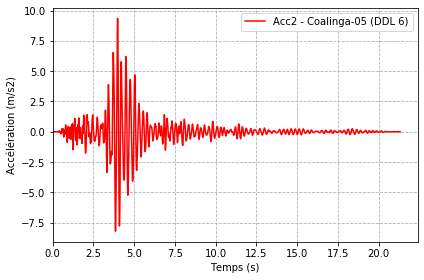

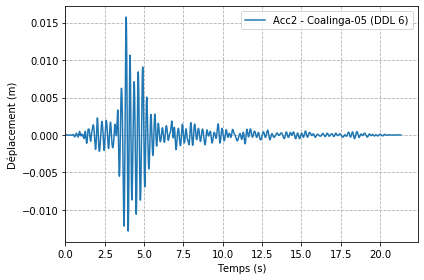

In [15]:
fig,ax = plt.subplots()
ax.plot(res_line["TIME"],res_line["A"][6],color="r",label="{} (DDL 6)".format(cas))
ax.set_xlabel("Temps (s)")
ax.set_ylabel("Accélération (m/s2)")
ax.set_xlim([0,None])
ax.grid(ls="--")
ax.legend()
fig.tight_layout()

fig,ax = plt.subplots()
ax.plot(res_line["TIME"],res_line["U"][6],label="{} (DDL 6)".format(cas))
ax.set_xlabel("Temps (s)")
ax.set_ylabel("Déplacement (m)")
ax.set_xlim([0,None])
ax.grid(ls="--")
ax.legend()
fig.tight_layout()

## Calcul nonlinéaire avec prise en compte du décollement

## Calcul nonlinéaire avec prise en compte du glissement

## Calcul nonlinéaire avec prise en compte du décollement et du glissement